<a href="https://colab.research.google.com/github/Hamedsamak66/Big-Mart-Sales-Prediction-Datasets/blob/main/Big-Mart-Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib xgboost lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [134]:
train_data = pd.read_csv('/content/sample_data/train.csv')
test_data = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
data = pd.concat([train_data, test_data], sort=False)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB
None
        Item_Weight  Item_Visibility      Item

In [ ]:
imputer = SimpleImputer(strategy='mean')
data['Item_Weight'] = imputer.fit_transform(data[['Item_Weight']])
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)

In [ ]:
le = LabelEncoder()
data['Item_Fat_Content'] = le.fit_transform(data['Item_Fat_Content'])
data['Outlet_Location_Type'] = le.fit_transform(data['Outlet_Location_Type'])
data['Outlet_Size'] = le.fit_transform(data['Outlet_Size'])
data['Outlet_Type'] = le.fit_transform(data['Outlet_Type'])

data = pd.get_dummies(data, columns=['Item_Type'])

In [ ]:
data = data.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

In [ ]:
# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
data_poly = poly.fit_transform(data.drop(['Item_Outlet_Sales'], axis=1))

# Split the data back into train and test sets
train = data_poly[:len(train_data)]
test = data_poly[len(train_data):]

In [ ]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train)
X_test_scaled = scaler.transform(test)

In [ ]:
y = train_data['Item_Outlet_Sales']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 61]
}
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [ ]:
# Perform GridSearchCV and update models with best estimators
models["Random Forest"] = perform_grid_search(models["Random Forest"], param_grid_rf, X_train, y_train)
models["XGBoost"] = perform_grid_search(models["XGBoost"], param_grid_xgb, X_train, y_train)
models["LightGBM"] = perform_grid_search(models["LightGBM"], param_grid_lgb, X_train, y_train)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11058
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 180
[LightGBM] [Info] Start training from score 2202.365232


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [ ]:
# Evaluate all models
results = {}
for model_name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, X_val, y_train, y_val)
    results[model_name] = {"RMSE": rmse, "R2": r2}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11058
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 180
[LightGBM] [Info] Start training from score 2202.365232


In [ ]:
# Add Deep Learning model
def build_and_evaluate_nn(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [ ]:
rmse, r2 = build_and_evaluate_nn(X_train, X_val, y_train, y_val)
results["Deep Learning"] = {"RMSE": rmse, "R2": r2}


54/54 [==============================] - 0s 1ms/step


In [ ]:
for model_name, metrics in results.items():
    print(f"{model_name} - RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")

Linear Regression - RMSE: 1038.7182, R2: 0.6030
Random Forest - RMSE: 1046.1825, R2: 0.5973
Decision Tree - RMSE: 1470.1621, R2: 0.2048
XGBoost - RMSE: 1027.2158, R2: 0.6118
LightGBM - RMSE: 1047.5815, R2: 0.5962
Deep Learning - RMSE: 1045.4569, R2: 0.5979


<ipython-input-132-490f9d30532e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-132-490f9d30532e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(model_names, rotation=45, ha='right')


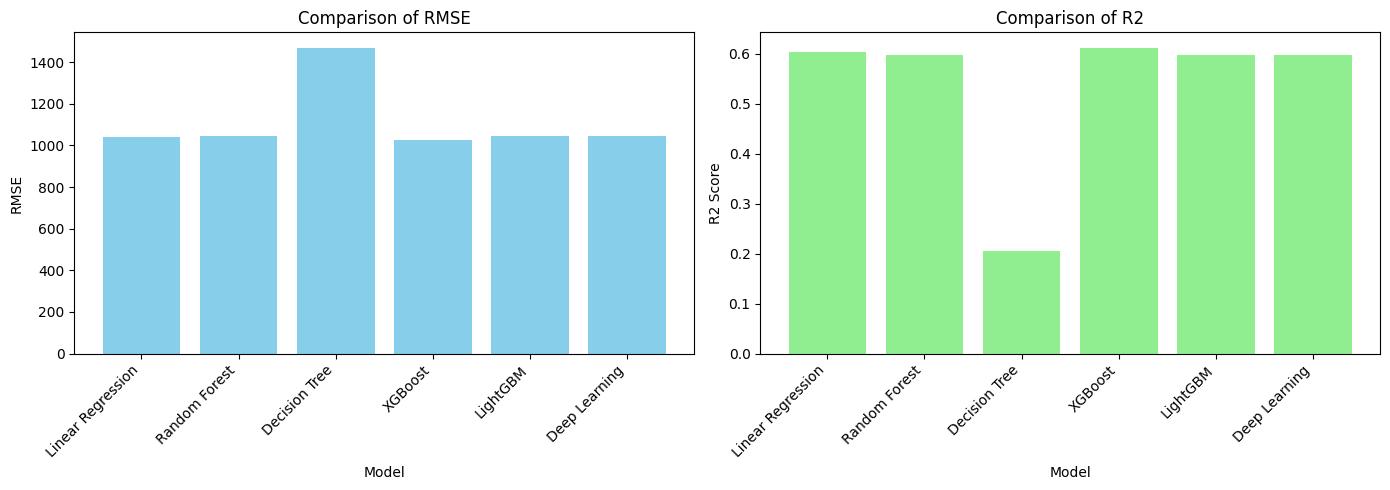

In [ ]:
# Plotting comparison charts for RMSE and R2
model_names = list(results.keys())
rmse_values = [results[model]["RMSE"] for model in model_names]
r2_values = [results[model]["R2"] for model in model_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE Bar Chart
axes[0].bar(model_names, rmse_values, color='skyblue')
axes[0].set_title('Comparison of RMSE')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_xticklabels(model_names, rotation=45, ha='right')

# R2 Bar Chart
axes[1].bar(model_names, r2_values, color='lightgreen')
axes[1].set_title('Comparison of R2')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R2 Score')
axes[1].set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()